# Simulated KB Mirror Demo using Ax and Blop

This notebook introduces the use of the [Ax Adaptive Experimentation Platform](https://ax.dev) with integrations for Blop.

Blop integrates the following into Ax:
- Running Bluesky plans using the run engine
- Using devices as parameters
- Using detectors to produce data
- Retrieving the results from databroker

These features make it simple to optimize your beamline using both the [Bluesky ecosystem](https://blueskyproject.io) and Ax.

## Preparing a test environment

Here we prepare the `RunEngine` and data service `Databroker`.

In [1]:
from blop.utils import prepare_re_env  # noqa

%run -i $prepare_re_env.__file__ --db-type=temp
bec.disable_plots()

## Simulated beamline with KB mirror pair

Here we describe an analytical simulated beamline with a [KB mirror](https://en.wikipedia.org/wiki/Kirkpatrick%E2%80%93Baez_mirror) pair.

In [2]:
from blop.sim import Beamline

beamline = Beamline(name="bl")
beamline.det.noise.put(False)

## Create a Blop-Ax experiment

Now we can define the experiment we plan to run.

This involves setting 4 parameters that simulate motor positions controlling two KB mirrors. The objectives of the experiment are to maximize the beam intensity while minimizing the area of the beam.

In [3]:
from ax.service.ax_client import AxClient, ObjectiveProperties
from blop.integrations.ax import create_blop_experiment

ax_client = AxClient()
create_blop_experiment(
    ax_client,
    parameters=[
        {
            "movable": beamline.kbv_dsv,
            "type": "range",
            "bounds": [-5.0, 5.0],
        },
        {
            "movable": beamline.kbv_usv,
            "type": "range",
            "bounds": [-5.0, 5.0],
        },
        {
            "movable": beamline.kbh_dsh,
            "type": "range",
            "bounds": [-5.0, 5.0],
        },
        {
            "movable": beamline.kbh_ush,
            "type": "range",
            "bounds": [-5.0, 5.0],
        },
    ],
    objectives={
        "beam_intensity": ObjectiveProperties(minimize=False, threshold=200.0),
        "beam_area": ObjectiveProperties(minimize=True, threshold=1000.0),
    },
)

[INFO 06-19 02:04:24] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter bl_kbv_dsv. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.


[INFO 06-19 02:04:24] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter bl_kbv_usv. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.


[INFO 06-19 02:04:24] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter bl_kbh_dsh. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.


[INFO 06-19 02:04:24] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter bl_kbh_ush. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.


[INFO 06-19 02:04:24] ax.generation_strategy.dispatch_utils: Using Generators.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.


[INFO 06-19 02:04:24] ax.generation_strategy.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+BoTorch', steps=[Sobol for 8 trials, BoTorch for subsequent trials]). Iterations after 8 will take longer to generate due to model-fitting.


## Create an evaluation function

Now that we have setup the experiment, we need to define how to compute the objective values.

In this example, the `RunEngine` produces readings from the detector that are retrieved from `Databroker` and transformed into a Pandas `DataFrame`. Using the image produced from this, we can compute some statistics from the image to produce the beam intensity and beam area (our objectives).

Ax expects a `tuple[float, float]` for each objective representing the mean value and standard error, respectively. For a single image, the average intensity is just the intensity (same for the area), and we assume no uncertainty.

In [4]:
import pandas as pd
from blop.utils import get_beam_stats


def evaluate(results_df: pd.DataFrame) -> dict[str, tuple[float, float]]:
    stats = get_beam_stats(results_df["bl_det_image"].iloc[0])
    area = stats["wid_x"] * stats["wid_y"]
    return {
        "beam_intensity": (stats["sum"], None),
        "beam_area": (area, None),
    }

## Create an evaluator

We need a Bluesky evaluator that actually launches the experiment using the `RunEngine` and retreives the result using `Databroker`. Here we need to specify which detectors will produce the image as well as which motors we will be moving. Also, we pass the evaulation function here to produce the objective values.

This evaluator will be used to produce the raw data needed by Ax to optimize the parameters to satisfy our objectives.

In [5]:
from blop.integrations.ax import create_bluesky_evaluator


evaluator = create_bluesky_evaluator(
    RE, db, [beamline.det], [beamline.kbv_dsv, beamline.kbv_usv, beamline.kbh_dsh, beamline.kbh_ush], evaluate
)

## Optimize!

Finally, with all of our experimental setup done, we can optimize the parameters to satisfy our objectives.

For this example, Ax will optimize the 4 motor positions to produce the greatest intensity beam with the smallest beam width and height (smallest area). It does this by first running a couple of `Trial`s which are random samples, then the remainder using Bayesian optimization through BoTorch.

A single Ax `Trial` represents the training and evaluation of BoTorch models to produce a suggested next `Arm`. An `Arm` in Ax is a single parameterization to be evaluated while a `Trial` can consist of many `Arm`s. In this demo, we have a single `Arm` per `Trial`.

In [6]:
for _ in range(25):
    parameterization, trial_index = ax_client.get_next_trial()
    ax_client.complete_trial(trial_index=trial_index, raw_data=evaluator(parameterization))

[INFO 06-19 02:04:24] ax.service.ax_client: Generated new trial 0 with parameters {'bl_kbv_dsv': 2.47674, 'bl_kbv_usv': 3.970543, 'bl_kbh_dsh': 1.290917, 'bl_kbh_ush': -3.837191} using model Sobol.


2025-06-19 02:04:24.574 INFO: Executing plan <generator object list_scan at 0x7f0151c22030>


2025-06-19 02:04:24.576 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'idle' -> 'running'




Transient Scan ID: 1     Time: 2025-06-19 02:04:24

Persistent Unique Scan ID: 'c783ae06-b6b4-4f94-b3cc-8b9d5c8cc6db'

New stream: 'primary'

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|         1 | 02:04:24.6 |      2.477 |      3.971 |      1.291 |     -3.837 |    251.691 |      124.764 |      171.133 |       46.063 |       87.347 |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

generator list_scan ['c783ae06'] (scan num: 1)

2025-06-19 02:04:24.811 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'running' -> 'idle'


2025-06-19 02:04:24.813 INFO: Cleaned up from plan <generator object list_scan at 0x7f0151c22030>


[INFO 06-19 02:04:24] ax.service.ax_client: Completed trial 0 with data: {'beam_intensity': (np.float64(251.690571), None), 'beam_area': (np.float64(4023.485725), None)}.


[INFO 06-19 02:04:24] ax.service.ax_client: Generated new trial 1 with parameters {'bl_kbv_dsv': -3.103842, 'bl_kbv_usv': -3.529084, 'bl_kbh_dsh': -4.083496, 'bl_kbh_ush': 4.977325} using model Sobol.


2025-06-19 02:04:24.887 INFO: Executing plan <generator object list_scan at 0x7f0151c22260>


2025-06-19 02:04:24.888 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'idle' -> 'running'




Transient Scan ID: 2     Time: 2025-06-19 02:04:24

Persistent Unique Scan ID: 'bc4a6e71-d660-4513-9a93-b7f1dc42fac9'

New stream: 'primary'

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|         1 | 02:04:24.9 |     -3.104 |     -3.529 |     -4.083 |      4.977 |      0.000 |        0.000 |        0.000 |        0.000 |        0.000 |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

generator list_scan ['bc4a6e71'] (scan num: 2)

2025-06-19 02:04:25.061 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'running' -> 'idle'


2025-06-19 02:04:25.063 INFO: Cleaned up from plan <generator object list_scan at 0x7f0151c22260>


[INFO 06-19 02:04:25] ax.service.ax_client: Completed trial 1 with data: {'beam_intensity': (0.0, None), 'beam_area': (0.0, None)}.


[INFO 06-19 02:04:25] ax.service.ax_client: Generated new trial 2 with parameters {'bl_kbv_dsv': -1.814364, 'bl_kbv_usv': 0.029722, 'bl_kbh_dsh': 4.336352, 'bl_kbh_ush': -2.490621} using model Sobol.


2025-06-19 02:04:25.122 INFO: Executing plan <generator object list_scan at 0x7f0151c22730>


2025-06-19 02:04:25.123 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'idle' -> 'running'




Transient Scan ID: 3     Time: 2025-06-19 02:04:25

Persistent Unique Scan ID: 'bb24f729-3166-4a86-8680-4f54013ba479'

New stream: 'primary'

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|         1 | 02:04:25.1 |     -1.814 |      0.030 |      4.336 |     -2.491 |      0.000 |       97.985 |      176.500 |        3.522 |       72.000 |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

generator list_scan ['bb24f729'] (scan num: 3)

2025-06-19 02:04:25.284 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'running' -> 'idle'


2025-06-19 02:04:25.285 INFO: Cleaned up from plan <generator object list_scan at 0x7f0151c22730>


[INFO 06-19 02:04:25] ax.service.ax_client: Completed trial 2 with data: {'beam_intensity': (np.float64(1e-06), None), 'beam_area': (np.float64(253.575512), None)}.


[INFO 06-19 02:04:25] ax.service.ax_client: Generated new trial 3 with parameters {'bl_kbv_dsv': 3.686578, 'bl_kbv_usv': -2.470649, 'bl_kbh_dsh': -1.504979, 'bl_kbh_ush': 1.350484} using model Sobol.


2025-06-19 02:04:25.356 INFO: Executing plan <generator object list_scan at 0x7f0151c21af0>


2025-06-19 02:04:25.358 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'idle' -> 'running'




Transient Scan ID: 4     Time: 2025-06-19 02:04:25

Persistent Unique Scan ID: '1cc87ad8-fade-4a71-a65d-f959e7a65001'

New stream: 'primary'

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|         1 | 02:04:25.4 |      3.687 |     -2.471 |     -1.505 |      1.350 |      0.203 |      255.833 |       73.929 |       33.233 |        3.478 |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

generator list_scan ['1cc87ad8'] (scan num: 4)

2025-06-19 02:04:25.522 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'running' -> 'idle'


2025-06-19 02:04:25.524 INFO: Cleaned up from plan <generator object list_scan at 0x7f0151c21af0>


[INFO 06-19 02:04:25] ax.service.ax_client: Completed trial 3 with data: {'beam_intensity': (np.float64(0.202628), None), 'beam_area': (np.float64(115.568917), None)}.


[INFO 06-19 02:04:25] ax.service.ax_client: Generated new trial 4 with parameters {'bl_kbv_dsv': 4.357042, 'bl_kbv_usv': 1.505792, 'bl_kbh_dsh': -3.185226, 'bl_kbh_ush': 0.062057} using model Sobol.


2025-06-19 02:04:25.587 INFO: Executing plan <generator object list_scan at 0x7f0151c22030>


2025-06-19 02:04:25.589 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'idle' -> 'running'




Transient Scan ID: 5     Time: 2025-06-19 02:04:25

Persistent Unique Scan ID: '4d38df83-7264-4441-951b-c1c2991f6c34'

New stream: 'primary'

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|         1 | 02:04:25.6 |      4.357 |      1.506 |     -3.185 |      0.062 |    364.597 |      250.276 |      112.104 |       87.299 |       67.798 |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

generator list_scan ['4d38df83'] (scan num: 5)

2025-06-19 02:04:25.750 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'running' -> 'idle'


2025-06-19 02:04:25.751 INFO: Cleaned up from plan <generator object list_scan at 0x7f0151c22030>


[INFO 06-19 02:04:25] ax.service.ax_client: Completed trial 4 with data: {'beam_intensity': (np.float64(364.597156), None), 'beam_area': (np.float64(5918.722626), None)}.


[INFO 06-19 02:04:25] ax.service.ax_client: Generated new trial 5 with parameters {'bl_kbv_dsv': -1.234213, 'bl_kbv_usv': -0.993837, 'bl_kbh_dsh': 0.939797, 'bl_kbh_ush': -1.124075} using model Sobol.


2025-06-19 02:04:25.812 INFO: Executing plan <generator object list_scan at 0x7f0151c22730>


2025-06-19 02:04:25.813 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'idle' -> 'running'




Transient Scan ID: 6     Time: 2025-06-19 02:04:25

Persistent Unique Scan ID: '3ad9a2eb-16d7-4c2b-87a9-a90efd676506'

New stream: 'primary'

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|         1 | 02:04:25.8 |     -1.234 |     -0.994 |      0.940 |     -1.124 |    535.607 |      157.683 |      152.569 |       35.351 |       83.705 |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

generator list_scan ['3ad9a2eb'] (scan num: 6)

2025-06-19 02:04:25.970 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'running' -> 'idle'


2025-06-19 02:04:25.971 INFO: Cleaned up from plan <generator object list_scan at 0x7f0151c22730>


[INFO 06-19 02:04:26] ax.service.ax_client: Completed trial 5 with data: {'beam_intensity': (np.float64(535.606544), None), 'beam_area': (np.float64(2959.055596), None)}.


[INFO 06-19 02:04:26] ax.service.ax_client: Generated new trial 6 with parameters {'bl_kbv_dsv': -4.946176, 'bl_kbv_usv': 2.653167, 'bl_kbh_dsh': -1.2311, 'bl_kbh_ush': 3.610736} using model Sobol.


2025-06-19 02:04:26.032 INFO: Executing plan <generator object list_scan at 0x7f0151c22650>


2025-06-19 02:04:26.034 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'idle' -> 'running'




Transient Scan ID: 7     Time: 2025-06-19 02:04:26

Persistent Unique Scan ID: 'f42274d5-8260-46df-a9de-5963cd2c91c5'

New stream: 'primary'

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|         1 | 02:04:26.0 |     -4.946 |      2.653 |     -1.231 |      3.611 |     39.913 |      286.341 |      216.000 |       21.911 |       14.287 |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

generator list_scan ['f42274d5'] (scan num: 7)

2025-06-19 02:04:26.198 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'running' -> 'idle'


2025-06-19 02:04:26.200 INFO: Cleaned up from plan <generator object list_scan at 0x7f0151c22650>


[INFO 06-19 02:04:26] ax.service.ax_client: Completed trial 6 with data: {'beam_intensity': (np.float64(39.913418), None), 'beam_area': (np.float64(313.037956), None)}.


[INFO 06-19 02:04:26] ax.service.ax_client: Generated new trial 7 with parameters {'bl_kbv_dsv': 0.568469, 'bl_kbv_usv': -4.847206, 'bl_kbh_dsh': 3.359621, 'bl_kbh_ush': -2.548732} using model Sobol.


2025-06-19 02:04:26.273 INFO: Executing plan <generator object list_scan at 0x7f015099ff40>


2025-06-19 02:04:26.274 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'idle' -> 'running'




Transient Scan ID: 8     Time: 2025-06-19 02:04:26

Persistent Unique Scan ID: '02515c0f-8307-4754-9ca6-6c6657730532'

New stream: 'primary'

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|         1 | 02:04:26.3 |      0.568 |     -4.847 |      3.360 |     -2.549 |      0.020 |       98.492 |      105.817 |        2.687 |       56.167 |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

generator list_scan ['02515c0f'] (scan num: 8)

2025-06-19 02:04:26.441 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'running' -> 'idle'


2025-06-19 02:04:26.443 INFO: Cleaned up from plan <generator object list_scan at 0x7f015099ff40>


[INFO 06-19 02:04:26] ax.service.ax_client: Completed trial 7 with data: {'beam_intensity': (np.float64(0.019606), None), 'beam_area': (np.float64(150.93821), None)}.


[INFO 06-19 02:04:28] ax.service.ax_client: Generated new trial 8 with parameters {'bl_kbv_dsv': 1.017299, 'bl_kbv_usv': -4.183443, 'bl_kbh_dsh': 0.906745, 'bl_kbh_ush': -0.849314} using model BoTorch.


2025-06-19 02:04:28.790 INFO: Executing plan <generator object list_scan at 0x7f0150967840>


2025-06-19 02:04:28.792 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'idle' -> 'running'




Transient Scan ID: 9     Time: 2025-06-19 02:04:28

Persistent Unique Scan ID: '1c366aae-e8fc-472f-8cc5-1edc826968cb'

New stream: 'primary'

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|         1 | 02:04:28.8 |      1.017 |     -4.183 |      0.907 |     -0.849 |    263.476 |      163.997 |      101.639 |       29.413 |       49.417 |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

generator list_scan ['1c366aae'] (scan num: 9)

2025-06-19 02:04:28.954 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'running' -> 'idle'


2025-06-19 02:04:28.956 INFO: Cleaned up from plan <generator object list_scan at 0x7f0150967840>


[INFO 06-19 02:04:29] ax.service.ax_client: Completed trial 8 with data: {'beam_intensity': (np.float64(263.476468), None), 'beam_area': (np.float64(1453.495093), None)}.


[INFO 06-19 02:04:31] ax.service.ax_client: Generated new trial 9 with parameters {'bl_kbv_dsv': -3.100072, 'bl_kbv_usv': 1.563656, 'bl_kbh_dsh': 1.073732, 'bl_kbh_ush': -0.865809} using model BoTorch.


2025-06-19 02:04:31.663 INFO: Executing plan <generator object list_scan at 0x7f0150967920>


2025-06-19 02:04:31.664 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'idle' -> 'running'




Transient Scan ID: 10     Time: 2025-06-19 02:04:31

Persistent Unique Scan ID: '42befa38-2127-4c5a-8998-50fb27825b9a'

New stream: 'primary'

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|         1 | 02:04:31.7 |     -3.100 |      1.564 |      1.074 |     -0.866 |    312.180 |      160.407 |      201.507 |       26.751 |       40.036 |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

generator list_scan ['42befa38'] (scan num: 10)

2025-06-19 02:04:31.844 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'running' -> 'idle'


2025-06-19 02:04:31.845 INFO: Cleaned up from plan <generator object list_scan at 0x7f0150967920>


[INFO 06-19 02:04:31] ax.service.ax_client: Completed trial 9 with data: {'beam_intensity': (np.float64(312.180407), None), 'beam_area': (np.float64(1070.993279), None)}.


[INFO 06-19 02:04:34] ax.service.ax_client: Generated new trial 10 with parameters {'bl_kbv_dsv': 4.534584, 'bl_kbv_usv': -2.68108, 'bl_kbh_dsh': -3.582397, 'bl_kbh_ush': 0.939174} using model BoTorch.


2025-06-19 02:04:34.355 INFO: Executing plan <generator object list_scan at 0x7f0151c22570>


2025-06-19 02:04:34.356 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'idle' -> 'running'




Transient Scan ID: 11     Time: 2025-06-19 02:04:34

Persistent Unique Scan ID: 'f4199b43-d67d-49f0-b7b2-ee4ca20f9656'

New stream: 'primary'

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|         1 | 02:04:34.4 |      4.535 |     -2.681 |     -3.582 |      0.939 |      0.000 |      266.000 |       71.000 |       59.400 |        1.800 |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

generator list_scan ['f4199b43'] (scan num: 11)

2025-06-19 02:04:34.515 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'running' -> 'idle'


2025-06-19 02:04:34.516 INFO: Cleaned up from plan <generator object list_scan at 0x7f0151c22570>


[INFO 06-19 02:04:34] ax.service.ax_client: Completed trial 10 with data: {'beam_intensity': (np.float64(0.0), None), 'beam_area': (np.float64(106.92), None)}.


[INFO 06-19 02:04:38] ax.service.ax_client: Generated new trial 11 with parameters {'bl_kbv_dsv': 5.0, 'bl_kbv_usv': -2.153158, 'bl_kbh_dsh': 0.939337, 'bl_kbh_ush': 1.336412} using model BoTorch.


2025-06-19 02:04:38.519 INFO: Executing plan <generator object list_scan at 0x7f0151c220a0>


2025-06-19 02:04:38.521 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'idle' -> 'running'




Transient Scan ID: 12     Time: 2025-06-19 02:04:38

Persistent Unique Scan ID: '2c83fc56-ee97-4be9-9be2-3df5f8607a3b'

New stream: 'primary'

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|         1 | 02:04:38.5 |      5.000 |     -2.153 |      0.939 |      1.336 |      0.000 |      207.000 |       71.000 |       39.600 |        1.800 |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

generator list_scan ['2c83fc56'] (scan num: 12)

2025-06-19 02:04:38.679 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'running' -> 'idle'


2025-06-19 02:04:38.680 INFO: Cleaned up from plan <generator object list_scan at 0x7f0151c220a0>


[INFO 06-19 02:04:38] ax.service.ax_client: Completed trial 11 with data: {'beam_intensity': (np.float64(0.0), None), 'beam_area': (np.float64(71.28), None)}.


[INFO 06-19 02:04:44] ax.service.ax_client: Generated new trial 12 with parameters {'bl_kbv_dsv': -5.0, 'bl_kbv_usv': 0.221345, 'bl_kbh_dsh': 5.0, 'bl_kbh_ush': -1.122738} using model BoTorch.


2025-06-19 02:04:44.144 INFO: Executing plan <generator object list_scan at 0x7f0151c222d0>


2025-06-19 02:04:44.146 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'idle' -> 'running'




Transient Scan ID: 13     Time: 2025-06-19 02:04:44

Persistent Unique Scan ID: 'a2b45ad0-649b-4503-91dd-66eac9f31aef'

New stream: 'primary'

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|         1 | 02:04:44.1 |     -5.000 |      0.221 |      5.000 |     -1.123 |     67.570 |      110.641 |      188.803 |       20.720 |       62.899 |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

generator list_scan ['a2b45ad0'] (scan num: 13)

2025-06-19 02:04:44.320 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'running' -> 'idle'


2025-06-19 02:04:44.321 INFO: Cleaned up from plan <generator object list_scan at 0x7f0151c222d0>


[INFO 06-19 02:04:44] ax.service.ax_client: Completed trial 12 with data: {'beam_intensity': (np.float64(67.5699), None), 'beam_area': (np.float64(1303.26663), None)}.


[INFO 06-19 02:04:50] ax.service.ax_client: Generated new trial 13 with parameters {'bl_kbv_dsv': -3.0567, 'bl_kbv_usv': 1.14143, 'bl_kbh_dsh': -1.091892, 'bl_kbh_ush': -1.866131} using model BoTorch.


2025-06-19 02:04:50.720 INFO: Executing plan <generator object list_scan at 0x7f015099ff40>


2025-06-19 02:04:50.721 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'idle' -> 'running'




Transient Scan ID: 14     Time: 2025-06-19 02:04:50

Persistent Unique Scan ID: '85d95121-6abb-4964-8b51-e49cd4fa0a31'

New stream: 'primary'

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|         1 | 02:04:50.7 |     -3.057 |      1.141 |     -1.092 |     -1.866 |    349.743 |      183.531 |      196.067 |      106.621 |       49.889 |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

generator list_scan ['85d95121'] (scan num: 14)

2025-06-19 02:04:50.881 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'running' -> 'idle'


2025-06-19 02:04:50.883 INFO: Cleaned up from plan <generator object list_scan at 0x7f015099ff40>


[INFO 06-19 02:04:50] ax.service.ax_client: Completed trial 13 with data: {'beam_intensity': (np.float64(349.742741), None), 'beam_area': (np.float64(5319.256331), None)}.


[INFO 06-19 02:04:54] ax.service.ax_client: Generated new trial 14 with parameters {'bl_kbv_dsv': 1.926163, 'bl_kbv_usv': 0.971834, 'bl_kbh_dsh': 2.534365, 'bl_kbh_ush': -0.775653} using model BoTorch.


2025-06-19 02:04:54.264 INFO: Executing plan <generator object list_scan at 0x7f0150967840>


2025-06-19 02:04:54.266 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'idle' -> 'running'




Transient Scan ID: 15     Time: 2025-06-19 02:04:54

Persistent Unique Scan ID: '6da4cf0f-054d-43d0-a847-346a89c78f7b'

New stream: 'primary'

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|         1 | 02:04:54.3 |      1.926 |      0.972 |      2.534 |     -0.776 |    552.490 |      133.000 |      134.583 |       25.895 |       19.833 |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

generator list_scan ['6da4cf0f'] (scan num: 15)

2025-06-19 02:04:54.431 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'running' -> 'idle'


2025-06-19 02:04:54.432 INFO: Cleaned up from plan <generator object list_scan at 0x7f0150967840>


[INFO 06-19 02:04:54] ax.service.ax_client: Completed trial 14 with data: {'beam_intensity': (np.float64(552.490038), None), 'beam_area': (np.float64(513.578947), None)}.


[INFO 06-19 02:04:57] ax.service.ax_client: Generated new trial 15 with parameters {'bl_kbv_dsv': 1.796484, 'bl_kbv_usv': 1.994748, 'bl_kbh_dsh': 2.752863, 'bl_kbh_ush': -0.557024} using model BoTorch.


2025-06-19 02:04:57.805 INFO: Executing plan <generator object list_scan at 0x7f01509678b0>


2025-06-19 02:04:57.807 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'idle' -> 'running'




Transient Scan ID: 16     Time: 2025-06-19 02:04:57

Persistent Unique Scan ID: '87f974a6-226c-4907-8de0-47b0905c2416'

New stream: 'primary'

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|         1 | 02:04:57.8 |      1.796 |      1.995 |      2.753 |     -0.557 |    552.703 |      132.972 |      151.988 |       35.864 |       36.361 |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

generator list_scan ['87f974a6'] (scan num: 16)

2025-06-19 02:04:57.969 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'running' -> 'idle'


2025-06-19 02:04:57.970 INFO: Cleaned up from plan <generator object list_scan at 0x7f01509678b0>


[INFO 06-19 02:04:58] ax.service.ax_client: Completed trial 15 with data: {'beam_intensity': (np.float64(552.702715), None), 'beam_area': (np.float64(1304.040727), None)}.


[INFO 06-19 02:05:00] ax.service.ax_client: Generated new trial 16 with parameters {'bl_kbv_dsv': 1.773354, 'bl_kbv_usv': -0.342606, 'bl_kbh_dsh': 3.685764, 'bl_kbh_ush': -0.59851} using model BoTorch.


2025-06-19 02:05:00.201 INFO: Executing plan <generator object list_scan at 0x7f015099ff40>


2025-06-19 02:05:00.203 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'idle' -> 'running'




Transient Scan ID: 17     Time: 2025-06-19 02:05:00

Persistent Unique Scan ID: 'eebedbc0-200e-44fb-b575-7231faf2f206'

New stream: 'primary'

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|         1 | 02:05:00.2 |      1.773 |     -0.343 |      3.686 |     -0.599 |    396.383 |      122.460 |      117.435 |       41.564 |       14.687 |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

generator list_scan ['eebedbc0'] (scan num: 17)

2025-06-19 02:05:00.364 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'running' -> 'idle'


2025-06-19 02:05:00.365 INFO: Cleaned up from plan <generator object list_scan at 0x7f015099ff40>


[INFO 06-19 02:05:00] ax.service.ax_client: Completed trial 16 with data: {'beam_intensity': (np.float64(396.382879), None), 'beam_area': (np.float64(610.456615), None)}.


[INFO 06-19 02:05:03] ax.service.ax_client: Generated new trial 17 with parameters {'bl_kbv_dsv': 1.106223, 'bl_kbv_usv': 0.716702, 'bl_kbh_dsh': 3.442751, 'bl_kbh_ush': -1.15576} using model BoTorch.


2025-06-19 02:05:03.246 INFO: Executing plan <generator object list_scan at 0x7f0150967840>


2025-06-19 02:05:03.248 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'idle' -> 'running'




Transient Scan ID: 18     Time: 2025-06-19 02:05:03

Persistent Unique Scan ID: '9fe46b15-0701-43cc-bd15-3112423c4ab6'

New stream: 'primary'

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|         1 | 02:05:03.2 |      1.106 |      0.717 |      3.443 |     -1.156 |    379.211 |      113.782 |      143.403 |       26.085 |        9.573 |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

generator list_scan ['9fe46b15'] (scan num: 18)

2025-06-19 02:05:03.410 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'running' -> 'idle'


2025-06-19 02:05:03.412 INFO: Cleaned up from plan <generator object list_scan at 0x7f0150967840>


[INFO 06-19 02:05:03] ax.service.ax_client: Completed trial 17 with data: {'beam_intensity': (np.float64(379.211103), None), 'beam_area': (np.float64(249.724061), None)}.


[INFO 06-19 02:05:05] ax.service.ax_client: Generated new trial 18 with parameters {'bl_kbv_dsv': 0.493904, 'bl_kbv_usv': 0.914769, 'bl_kbh_dsh': 2.589801, 'bl_kbh_ush': 0.398133} using model BoTorch.


2025-06-19 02:05:05.847 INFO: Executing plan <generator object list_scan at 0x7f01509678b0>


2025-06-19 02:05:05.849 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'idle' -> 'running'




Transient Scan ID: 19     Time: 2025-06-19 02:05:05

Persistent Unique Scan ID: '4b7693ec-5998-4bb2-aaa5-952de2caac5c'

New stream: 'primary'

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|         1 | 02:05:05.8 |      0.494 |      0.915 |      2.590 |      0.398 |    552.581 |      155.245 |      155.411 |       54.782 |       14.674 |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

generator list_scan ['4b7693ec'] (scan num: 19)

2025-06-19 02:05:06.004 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'running' -> 'idle'


2025-06-19 02:05:06.006 INFO: Cleaned up from plan <generator object list_scan at 0x7f01509678b0>


[INFO 06-19 02:05:06] ax.service.ax_client: Completed trial 18 with data: {'beam_intensity': (np.float64(552.580648), None), 'beam_area': (np.float64(803.843466), None)}.


[INFO 06-19 02:05:09] ax.service.ax_client: Generated new trial 19 with parameters {'bl_kbv_dsv': 3.926306, 'bl_kbv_usv': 0.483946, 'bl_kbh_dsh': 3.253908, 'bl_kbh_ush': -1.322737} using model BoTorch.


2025-06-19 02:05:09.341 INFO: Executing plan <generator object list_scan at 0x7f015099ff40>


2025-06-19 02:05:09.342 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'idle' -> 'running'




Transient Scan ID: 20     Time: 2025-06-19 02:05:09

Persistent Unique Scan ID: '0509e1b5-c4ee-4ff8-b95a-f309d08ecb74'

New stream: 'primary'

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|         1 | 02:05:09.3 |      3.926 |      0.484 |      3.254 |     -1.323 |    371.497 |      111.834 |      100.047 |       22.771 |       44.573 |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

generator list_scan ['0509e1b5'] (scan num: 20)

2025-06-19 02:05:09.500 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'running' -> 'idle'


2025-06-19 02:05:09.502 INFO: Cleaned up from plan <generator object list_scan at 0x7f015099ff40>


[INFO 06-19 02:05:09] ax.service.ax_client: Completed trial 19 with data: {'beam_intensity': (np.float64(371.497215), None), 'beam_area': (np.float64(1014.95854), None)}.


[INFO 06-19 02:05:12] ax.service.ax_client: Generated new trial 20 with parameters {'bl_kbv_dsv': -0.512468, 'bl_kbv_usv': -2.740242, 'bl_kbh_dsh': -3.72119, 'bl_kbh_ush': -0.946482} using model BoTorch.


2025-06-19 02:05:12.661 INFO: Executing plan <generator object list_scan at 0x7f0150967840>


2025-06-19 02:05:12.664 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'idle' -> 'running'




Transient Scan ID: 21     Time: 2025-06-19 02:05:12

Persistent Unique Scan ID: 'fd9b54ff-a81f-4cd8-b62c-4b3bfd160002'

New stream: 'primary'

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|         1 | 02:05:12.7 |     -0.512 |     -2.740 |     -3.721 |     -0.946 |    345.728 |      234.118 |      124.400 |      116.475 |       90.044 |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

generator list_scan ['fd9b54ff'] (scan num: 21)

2025-06-19 02:05:12.843 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'running' -> 'idle'


2025-06-19 02:05:12.845 INFO: Cleaned up from plan <generator object list_scan at 0x7f0150967840>


[INFO 06-19 02:05:12] ax.service.ax_client: Completed trial 20 with data: {'beam_intensity': (np.float64(345.728262), None), 'beam_area': (np.float64(10487.833195), None)}.


[INFO 06-19 02:05:16] ax.service.ax_client: Generated new trial 21 with parameters {'bl_kbv_dsv': 4.395671, 'bl_kbv_usv': -1.083051, 'bl_kbh_dsh': -0.100125, 'bl_kbh_ush': -1.104761} using model BoTorch.


2025-06-19 02:05:16.824 INFO: Executing plan <generator object list_scan at 0x7f0151c220a0>


2025-06-19 02:05:16.826 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'idle' -> 'running'




Transient Scan ID: 22     Time: 2025-06-19 02:05:16

Persistent Unique Scan ID: '2d54fd33-1b74-4dfa-899c-fd2e043cb74d'

New stream: 'primary'

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|         1 | 02:05:16.8 |      4.396 |     -1.083 |     -0.100 |     -1.105 |    155.695 |      179.000 |       78.839 |       57.850 |        8.622 |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

generator list_scan ['2d54fd33'] (scan num: 22)

2025-06-19 02:05:17.009 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'running' -> 'idle'


2025-06-19 02:05:17.012 INFO: Cleaned up from plan <generator object list_scan at 0x7f0151c220a0>


[INFO 06-19 02:05:17] ax.service.ax_client: Completed trial 21 with data: {'beam_intensity': (np.float64(155.694859), None), 'beam_area': (np.float64(498.806638), None)}.


[INFO 06-19 02:05:20] ax.service.ax_client: Generated new trial 22 with parameters {'bl_kbv_dsv': 1.254248, 'bl_kbv_usv': 0.561186, 'bl_kbh_dsh': 2.427926, 'bl_kbh_ush': -1.434088} using model BoTorch.


2025-06-19 02:05:20.381 INFO: Executing plan <generator object list_scan at 0x7f0150967840>


2025-06-19 02:05:20.382 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'idle' -> 'running'




Transient Scan ID: 23     Time: 2025-06-19 02:05:20

Persistent Unique Scan ID: '27eab045-9270-45a8-a166-f018618feafd'

New stream: 'primary'

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|         1 | 02:05:20.4 |      1.254 |      0.561 |      2.428 |     -1.434 |    550.040 |      121.938 |      138.527 |       16.675 |        9.546 |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

generator list_scan ['27eab045'] (scan num: 23)

2025-06-19 02:05:20.545 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'running' -> 'idle'


2025-06-19 02:05:20.546 INFO: Cleaned up from plan <generator object list_scan at 0x7f0150967840>


[INFO 06-19 02:05:20] ax.service.ax_client: Completed trial 22 with data: {'beam_intensity': (np.float64(550.040269), None), 'beam_area': (np.float64(159.182115), None)}.


[INFO 06-19 02:05:24] ax.service.ax_client: Generated new trial 23 with parameters {'bl_kbv_dsv': 0.813137, 'bl_kbv_usv': 0.570572, 'bl_kbh_dsh': 2.777724, 'bl_kbh_ush': -2.313103} using model BoTorch.


2025-06-19 02:05:24.214 INFO: Executing plan <generator object list_scan at 0x7f01509678b0>


2025-06-19 02:05:24.215 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'idle' -> 'running'




Transient Scan ID: 24     Time: 2025-06-19 02:05:24

Persistent Unique Scan ID: 'd9d10484-2f0d-4818-87e3-8f81ef62c3a5'

New stream: 'primary'

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|         1 | 02:05:24.2 |      0.813 |      0.571 |      2.778 |     -2.313 |    240.588 |      104.441 |      145.365 |        9.573 |       14.396 |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

generator list_scan ['d9d10484'] (scan num: 24)

2025-06-19 02:05:24.379 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'running' -> 'idle'


2025-06-19 02:05:24.381 INFO: Cleaned up from plan <generator object list_scan at 0x7f01509678b0>


[INFO 06-19 02:05:24] ax.service.ax_client: Completed trial 23 with data: {'beam_intensity': (np.float64(240.587554), None), 'beam_area': (np.float64(137.817453), None)}.


[INFO 06-19 02:05:28] ax.service.ax_client: Generated new trial 24 with parameters {'bl_kbv_dsv': 1.136806, 'bl_kbv_usv': 0.731329, 'bl_kbh_dsh': 1.771282, 'bl_kbh_ush': -0.718351} using model BoTorch.


2025-06-19 02:05:28.178 INFO: Executing plan <generator object list_scan at 0x7f0151c220a0>


2025-06-19 02:05:28.180 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'idle' -> 'running'




Transient Scan ID: 25     Time: 2025-06-19 02:05:28

Persistent Unique Scan ID: 'd28de0b9-1705-4324-9cff-1d245c797912'

New stream: 'primary'

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|         1 | 02:05:28.2 |      1.137 |      0.731 |      1.771 |     -0.718 |    549.800 |      149.375 |      143.000 |       16.500 |        8.800 |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

generator list_scan ['d28de0b9'] (scan num: 25)

2025-06-19 02:05:28.370 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'running' -> 'idle'


2025-06-19 02:05:28.373 INFO: Cleaned up from plan <generator object list_scan at 0x7f0151c220a0>


[INFO 06-19 02:05:28] ax.service.ax_client: Completed trial 24 with data: {'beam_intensity': (np.float64(549.79964), None), 'beam_area': (np.float64(145.2), None)}.


## Analyze Results

Below we will show how we can use Ax to visualize the results and retrieve each step of the experiment that was run. This is where Ax becomes extremely useful for beamline optimization.

In [7]:
ax_client.experiment.to_df()

,trial_index,arm_name,trial_status,generation_node,beam_intensity,beam_area,bl_kbv_dsv,bl_kbv_usv,bl_kbh_dsh,bl_kbh_ush
0,0,0_0,COMPLETED,GenerationStep_0,2.516906e+02,4023.485725,2.476740,3.970543,1.290917,-3.837191
1,1,1_0,COMPLETED,GenerationStep_0,0.000000e+00,0.000000,-3.103842,-3.529084,-4.083496,4.977325
2,2,2_0,COMPLETED,GenerationStep_0,1.004831e-06,253.575512,-1.814364,0.029722,4.336352,-2.490621
3,3,3_0,COMPLETED,GenerationStep_0,2.026283e-01,115.568917,3.686578,-2.470649,-1.504979,1.350484
4,4,4_0,COMPLETED,GenerationStep_0,3.645972e+02,5918.722626,4.357042,1.505792,-3.185226,0.062057
5,5,5_0,COMPLETED,GenerationStep_0,5.356065e+02,2959.055596,-1.234213,-0.993837,0.939797,-1.124075
6,6,6_0,COMPLETED,GenerationStep_0,3.991342e+01,313.037956,-4.946176,2.653167,-1.231100,3.610736
7,7,7_0,COMPLETED,GenerationStep_0,1.960563e-02,150.938210,0.568469,-4.847206,3.359621,-2.548732
8,8,8_0,COMPLETED,GenerationStep_1,2.634765e+02,1453.495093,1.017299,-4.183443,0.906745,-0.849314
9,9,9_0,COMPLETED,GenerationStep_1,3.121804e+02,1070.993279,-3.100072,1.563656,1.073732,-0.865809


### Viewing slices of parameter space

In [8]:
from ax.utils.notebook.plotting import render
from ax.plot.slice import plot_slice

model = ax_client.generation_strategy.model
render(plot_slice(model, "bl_kbv_dsv", "beam_intensity"))

In [9]:
render(plot_slice(model, "bl_kbv_dsv", "beam_area"))

### Viewing each arm's objective values

In [10]:
from ax.plot.scatter import interact_fitted

render(interact_fitted(model, rel=False))


### Visualizing the optimal beam

Below we get the optimal parameters, move the motors to their optimal positions, and observe the resulting beam.

In [11]:
optimal_arm = next(iter(ax_client.get_pareto_optimal_parameters()))
optimal_parameters = ax_client.get_trial(optimal_arm).arm.parameters
optimal_parameters

{'bl_kbv_dsv': 1.1368056037733205,
 'bl_kbv_usv': 0.7313293282888035,
 'bl_kbh_dsh': 1.7712815474194552,
 'bl_kbh_ush': -0.7183505817725625}

In [12]:
from bluesky.plans import list_scan

scan_motor_params = []
for motor in [beamline.kbv_dsv, beamline.kbv_usv, beamline.kbh_dsh, beamline.kbh_ush]:
    scan_motor_params.append(motor)
    scan_motor_params.append([optimal_parameters[motor.name]])
RE(list_scan([beamline.det], *scan_motor_params))

2025-06-19 02:05:29.929 INFO: Executing plan <generator object list_scan at 0x7f01489d4970>


2025-06-19 02:05:29.931 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'idle' -> 'running'




Transient Scan ID: 26     Time: 2025-06-19 02:05:29

Persistent Unique Scan ID: '06032ac9-2483-44c4-8796-b7bdcf52057a'

New stream: 'primary'

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

|         1 | 02:05:29.9 |      1.137 |      0.731 |      1.771 |     -0.718 |    549.800 |      149.375 |      143.000 |       16.500 |        8.800 |

+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+

generator list_scan ['06032ac9'] (scan num: 26)

2025-06-19 02:05:30.102 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f015aa8e920> from 'running' -> 'idle'


2025-06-19 02:05:30.103 INFO: Cleaned up from plan <generator object list_scan at 0x7f01489d4970>


('06032ac9-2483-44c4-8796-b7bdcf52057a',)

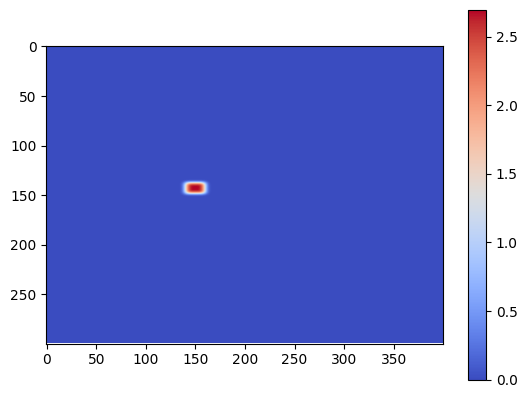

In [13]:
import matplotlib.pyplot as plt


plt.imshow(db[-1].table(fill=True)["bl_det_image"].iloc[0])
plt.colorbar()
plt.show()